# 

In [1]:
import pandas as pd
from utils import (
    compare_test_with_predicition,
    fit_model,
    get_parkings_df, 
    get_parkings_in_zone,
    get_hourly_parkings,
    get_pipeline,
    get_weather_data,
    add_seasonability_columns,
    predict,
    plot_predictions,
    SEASONABILITY_COLUMNS,
    RAIN,
    TEMPERATURE,
    YEAR,
    ONEHOT_SCALER_COLUMNS
)

# Load and prepare data

In [2]:
df_parkings = get_parkings_df("../data/parkings_small.csv")
parkings_in_zone = get_parkings_in_zone(df_parkings, 1)
print(f"Found {len(parkings_in_zone)} parkings in zone")
hourly_parkings = get_hourly_parkings(parkings_in_zone)
# clean data by removing early data days without cars
hourly_parkings = hourly_parkings[hourly_parkings["ds"]> "2024-5-20"]
df_rain, df_temperature = get_weather_data()
hourly_parking = pd.merge(hourly_parkings, df_rain, on="ds", how='left')
hourly_parking = pd.merge(hourly_parking, df_temperature, on="ds", how='left')
hourly_parking.head()
df = hourly_parking.copy()
df.set_index("ds", inplace=True)

df_rain_train = pd.merge(hourly_parkings, df_rain, on="ds", how='left')
df_rain_train.set_index("ds", inplace=True)

df_temperature_train = pd.merge(hourly_parkings, df_temperature, on="ds", how='left')
df_temperature_train.set_index("ds", inplace=True)


Found 718955 parkings in zone


#

mean squared error: 5598.766015697399
mean absolute percentage error 1205609847111092.8


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'month',
                                                   'dayofweek']),
                                                 ('Standard', StandardScaler(),
                                                  ['year'])])),
                ('regressor', LinearRegression())])

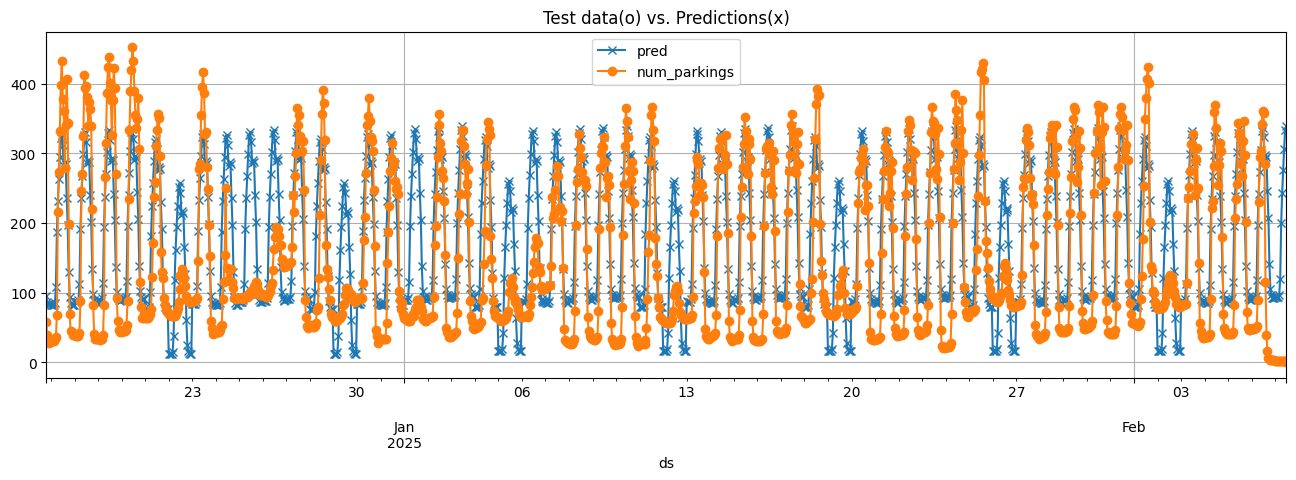

In [3]:
df = add_seasonability_columns(df)
pipeline = get_pipeline(standard_columns=[YEAR])
X_test, y_test = fit_model(pipeline, df, SEASONABILITY_COLUMNS)
compare_test_with_predicition(pipeline, X_test, y_test)

mean squared error: 5602.823520188579
mean absolute percentage error 1205852695494345.5
mean squared error: 5859.256605465568
mean absolute percentage error 1227701641448147.8


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'month',
                                                   'dayofweek']),
                                                 ('Standard', StandardScaler(),
                                                  ['temperature', 'year'])])),
                ('regressor', LinearRegression())])

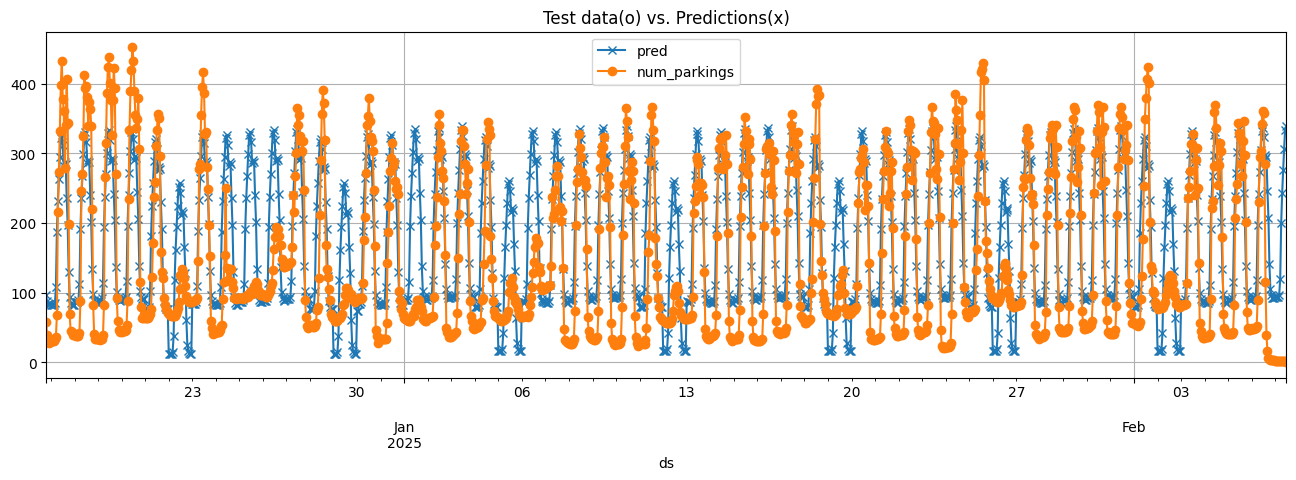

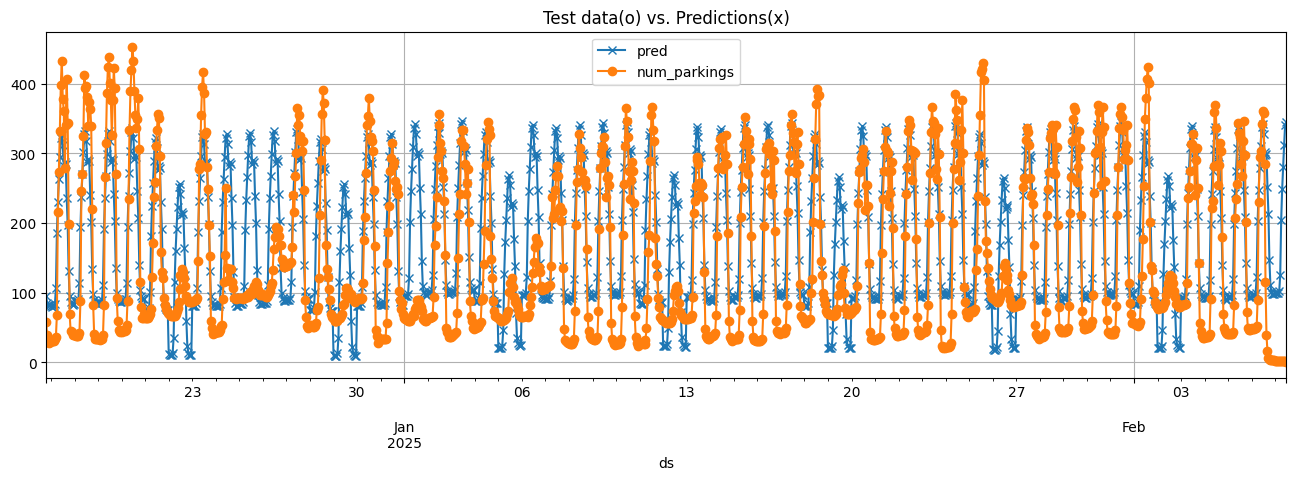

In [4]:
df_rain_train = add_seasonability_columns(df_rain_train)
pipeline_rain = get_pipeline(standard_columns=[YEAR, RAIN])
X_test, y_test = fit_model(pipeline_rain, df_rain_train, SEASONABILITY_COLUMNS+[RAIN])
compare_test_with_predicition(pipeline_rain, X_test, y_test)
df_temperature_train = add_seasonability_columns(df_temperature_train)
pipeline_temperature = get_pipeline(standard_columns=[TEMPERATURE, YEAR])
X_test, y_test = fit_model(pipeline_temperature, df_temperature_train, SEASONABILITY_COLUMNS+[TEMPERATURE])
compare_test_with_predicition(pipeline_temperature, X_test, y_test)

# Predictions

In [5]:
date_range = pd.date_range(start="2025-02-07 11:00:00", end="2025-03-09 11:00:00", freq="h")
base_predictions, base_total = predict(pipeline, date_range)
#plot_predictions(predictions)

# Correlation between rain and dry weather


In [6]:

predictions_rain, rain_total = predict(pipeline_rain, date_range, rain=True)
predictions_dry, dry_weather_total = predict(pipeline_rain, date_range, rain=False)
predictions_minus20, temp_minus20_total = predict(pipeline_temperature, date_range, temperature=-20)
predictions_minus10, temp_minus10_total = predict(pipeline_temperature, date_range, temperature=-10)
predictions_0, temp_0_total = predict(pipeline_temperature, date_range, temperature=0)
predictions_plus10, temp_plus10_total = predict(pipeline_temperature, date_range, temperature=10)
predictions_plus20, temp_plus20_total = predict(pipeline_temperature, date_range, temperature=20)


print(f"Forecast period: {date_range.min()} - {date_range.max()}")
print(f'Baseline forecast cars: {base_total}')
print(f'Rain forecast cars: {rain_total}. Diff to baseline: {rain_total-base_total}')
print(f'Dry weather forecast cars: {dry_weather_total}. Diff to baseline: {dry_weather_total-base_total}')
print(f'Temp -20 forecast cars: {temp_minus20_total}. Diff to baseline: {temp_minus20_total-base_total}')
print(f'Temp -10 forecast cars: {temp_minus10_total}. Diff to baseline: {temp_minus10_total-base_total}')
print(f'Temp 0 forecast cars: {temp_0_total}. Diff to baseline: {temp_0_total-base_total}')
print(f'Temp +10 forecast cars: {temp_plus10_total}. Diff to baseline: {temp_plus10_total-base_total}')
print(f'Temp +20 forecast cars: {temp_plus20_total}. Diff to baseline: {temp_plus20_total-base_total}')


Forecast period: 2025-02-07 11:00:00 - 2025-03-09 11:00:00
Baseline forecast cars: 125807
Rain forecast cars: 118484. Diff to baseline: -7323
Dry weather forecast cars: 125860. Diff to baseline: 53
Temp -20 forecast cars: 135569. Diff to baseline: 9762
Temp -10 forecast cars: 132561. Diff to baseline: 6754
Temp 0 forecast cars: 129552. Diff to baseline: 3745
Temp +10 forecast cars: 126544. Diff to baseline: 737
Temp +20 forecast cars: 123535. Diff to baseline: -2272
